### Visualization of our EEG data 
A notebook with different methods to visualize our data and results of classification  
Author: Shateesh Bhugwansing

In [3]:
%run ../preprocessing/StimCodes.ipynb
import mne
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams.update({'font.size': 11})

In [22]:
path = '/Users/shateeshbhugwansing/Desktop/seniorprojecteeg/Visualization/'
montage = mne.channels.read_montage(kind="ANT_DukeWaveGuard_128_electrode_montage_copy", ch_names=None, path=path, unit='mm', transform=False)

In [23]:
montage

<Montage | ANT_DukeWaveGuard_128_electrode_montage_copy - 127 channels: LE1, Nz, LE3 ...>

In [24]:
epoch.set_montage(montage)

The following EEG sensors did not have a position specified in the selected montage: ['Lm', 'Nasium', 'LL4', 'L12', 'VEOG']. Their position has been left untouched.


<ipython-input-24-2b9523d69e31>:1: RuntimeWarning: The following EEG sensors did not have a position specified in the selected montage: ['Lm', 'Nasium', 'LL4', 'L12', 'VEOG']. Their position has been left untouched.
  epoch.set_montage(montage)


<EpochsFIF  |   5424 events (all good), -0.199219 - 0.5 sec, baseline [-0.199219, 0], ~961.2 MB, data loaded,
 'congruent': 320
 'correct': 231
 'f_baby': 68
 'f_bell': 48
 'f_bird': 48
 'f_burp': 28
 'f_dog': 64
 'f_drum': 60
 'f_knock': 56
 'f_laugh': 96
 'f_phone': 84
 'f_train': 56
 'f_water': 32
 'flanker_stim_1': 100
 'flanker_stim_10': 80
 'flanker_stim_11': 80
 'flanker_stim_12': 60
 'flanker_stim_2': 100
 'flanker_stim_3': 100
 'flanker_stim_4': 61
 'flanker_stim_5': 60
 'flanker_stim_6': 60
 'flanker_stim_7': 100
 'flanker_stim_8': 100
 'flanker_stim_9': 120
 'incongruent': 320
 'incorrect': 37
 'left_button': 334
 'right_button': 342
 't_baby': 60
 't_bell': 50
 't_bird': 50
 't_burp': 60
 't_dog': 60
 't_drum': 50
 't_knock': 60
 't_laugh': 70
 't_phone': 60
 't_train': 70
 't_water': 50
 'target_stim_13': 59
 'target_stim_14': 60
 'target_stim_15': 100
 'target_stim_16': 80
 'target_stim_17': 80
 'target_stim_18': 80
 'target_stim_19': 100
 'target_stim_20': 100
 'target_s

/Users/shateeshbhugwansing/anaconda/envs/mne/lib/python3.6/site-packages/mne/transforms.py:690: RuntimeWarning: invalid value encountered in true_divide
  out[:, 2] = np.arccos(cart[:, 2] / out[:, 0])


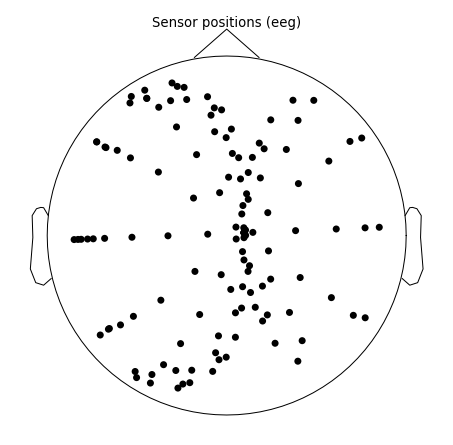

In [27]:
epoch.plot_sensors();

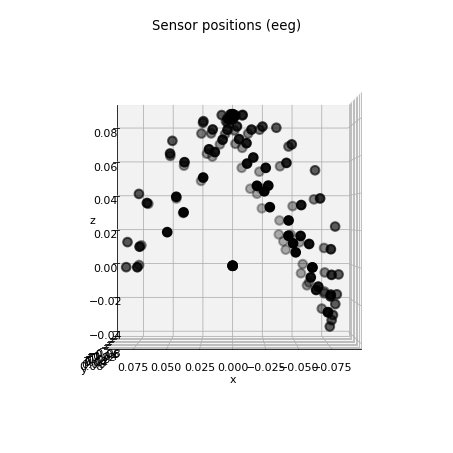

In [28]:
epoch.plot_sensors('3d');

### Topography Map

In [8]:
# read in data 
epoch_path = '/Volumes/SB/EpochedEEG/20131216_1441_epo.fif'
epoch = mne.read_epochs(epoch_path, preload=True)

Reading /Volumes/SB/EpochedEEG/20131216_1441_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...     500.00 ms
        0 CTF compensation matrices available
5424 matching events found
Applying baseline correction (mode: mean)
5424 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


In [9]:
projs = mne.compute_proj_epochs(epoch)

No gradiometers found. Forcing n_grad to 0
No magnetometers found. Forcing n_mag to 0
Adding projection: eeg-Multiple-events--0.199-0.500-PCA-01
Adding projection: eeg-Multiple-events--0.199-0.500-PCA-02


In [10]:
epoch_projs = epoch.add_proj(projs)

2 projection items deactivated


In [11]:
type(epoch_projs)

mne.epochs.EpochsFIF

In [12]:
type(epoch)

mne.epochs.EpochsFIF

In [13]:
epoch_projs.plot_projs_topomap()

Fitted sphere radius:         0.0 mm
Origin head coordinates:      0.0 0.0 0.0 mm
Origin device coordinates:    0.0 0.0 0.0 mm


ValueError: The following electrodes have overlapping positions, which causes problems during visualization:
Lm, LE1, Nasium, LE3, LD2, LD5, LC3, LC6, LB1, LB4, LA2, LA5, LL1, LL4, LL7, LL10, LL13, L3, L6, L9, L12, Z1, Z4, Z7, Z10, Z13, R3, R6, R9, R12, RR1, RR4, RR7, RR10, RR13, RA2, RA5, RB1, RB4, RC3, RC6, RD2, RD5, RE1, VEOG, RE3, Rm, RE4, RD1, RD3, RD4, RD6, RD7, RC1, RC2, RC4, RC5, RC7, RB2, RB3, RB5, RB6, RA1, RA3, RA4, RR2, RR3, RR5, RR6, RR8, RR9, RR11, RR12, R1, R2, R4, R5, R7, R8, R10, R11, R13, R14, Z2, Z3, Z5, Z6, Z8, Z9, Z11, Z12, Z14, L1, L2, L4, L5, L7, L8, L10, L11, L13, L14, LL2, LL3, LL5, LL6, LL8, LL9, LL11, LL12, LA1, LA3, LA4, LB2, LB3, LB5, LB6, LC1, LC2, LC4, LC5, LC7, LD1, LD3, LD4, LD6, LD7, LE4

In [14]:
epoch.plot_projs_topomap()

Fitted sphere radius:         0.0 mm
Origin head coordinates:      0.0 0.0 0.0 mm
Origin device coordinates:    0.0 0.0 0.0 mm


ValueError: The following electrodes have overlapping positions, which causes problems during visualization:
Lm, LE1, Nasium, LE3, LD2, LD5, LC3, LC6, LB1, LB4, LA2, LA5, LL1, LL4, LL7, LL10, LL13, L3, L6, L9, L12, Z1, Z4, Z7, Z10, Z13, R3, R6, R9, R12, RR1, RR4, RR7, RR10, RR13, RA2, RA5, RB1, RB4, RC3, RC6, RD2, RD5, RE1, VEOG, RE3, Rm, RE4, RD1, RD3, RD4, RD6, RD7, RC1, RC2, RC4, RC5, RC7, RB2, RB3, RB5, RB6, RA1, RA3, RA4, RR2, RR3, RR5, RR6, RR8, RR9, RR11, RR12, R1, R2, R4, R5, R7, R8, R10, R11, R13, R14, Z2, Z3, Z5, Z6, Z8, Z9, Z11, Z12, Z14, L1, L2, L4, L5, L7, L8, L10, L11, L13, L14, LL2, LL3, LL5, LL6, LL8, LL9, LL11, LL12, LA1, LA3, LA4, LB2, LB3, LB5, LB6, LC1, LC2, LC4, LC5, LC7, LD1, LD3, LD4, LD6, LD7, LE4

### topomap() is not working. Maybe I need to manaully create a layout